<center><h1>Diabetic Retinopathy Detection</h1></center>
<center><img src="https://th.bing.com/th/id/OIP.mjlzlO2y3nkybFRy1cy-8AHaEK?rs=1&pid=ImgDetMain" width="1800px" height="200px"></center>

## Table of Content
<ul>
    <li><a href= "#1">1 - Introduction and Create Workspace</a></li>
    <ul>
        <li><a href= "#1-1">    1.1 Import Packages</a></li>
        <li><a href= "#1-2">    1.2 Create Classes and Function</a></li>
    </ul>
    <li><a href= "#2">2 - Pre-Training on Diabetic Retinopathy 2015 data</a></li>
    <ul>
    <li><a href= "#2-1">    2.1 Import Data</a></li>
    <li><a href= "#2-2">    2.2 Explore Data</a></li>
    <li><a href= "#2-3">    2.3 Preprocess and Augment Data</a></li>
    <li><a href= "#2-4">    2.4 - Using EFfienctNetB7 on Diabetic Retinopathy 2015 data</a></li>
        <ul>
    <li><a href= "#2-4-1">        2.4.1 Setup Model and Choose Hyperparameters</a></li>
    <li><a href= "#2-4-2">        2.4.2 Train Model on Diabetic Retinopathy 2015 data</a></li>
    <li><a href= "#2-4-3">        2.4.3 Evaluation</a></li>
         </ul>   
    </ul>
    <li><a href= "#3">3 - Training on Diabetic Retinopathy 2019 data</a></li>
    <ul>
    <li><a href= "#3-1">    3.1 Import Data</a></li>
    <li><a href= "#3-2">    3.2 Explore Data</a></li>
    <li><a href= "#3-3">    3.3 Preprocess and Augment Data</a></li>
    <li><a href= "#3-4">    3.4 - Load Pre-Trained EFfienctNetB7 trained on 2015 data</a></li>
        <ul>
    <li><a href= "#3-4-1">        3.4.1 Setup Model and Choose Hyperparameters</a></li>
    <li><a href= "#3-4-2">        3.4.2 Train Model on Diabetic Retinopathy 2019 data</a></li>
    <li><a href= "#3-4-3">        3.4.3 Evaluation</a></li>
        </ul>
        </ul>
</ul>

<a name='1-1'></a>
## 1.1 Import Packages

In [23]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')
!mkdir models

mkdir: cannot create directory ‘models’: File exists


<a name='1-2'></a>

## 1.2 Create Classes and Function

In [25]:
# seed function
def seed_everything(seed = 23):
    # tests
    assert isinstance(seed, int), 'seed has to be an integer'
    
    # randomness
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
image_size = 256
#IMAGE PREPROCESSING

def prepare_image(path, 
                  sigmaX         = 10, 
                  do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [27]:
#CROP FUNCTIONS

def crop_black(img, 
               tol = 7):
    
    '''
    Perform automatic crop of black areas
    '''
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img


In [28]:
def circle_crop(img, 
                sigmaX = 10):   
    
    '''
    Perform circular crop around image center
    '''
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 


In [29]:
def random_crop(img, 
                size = (0.9, 1)):
    
    '''
    Random crop
    '''

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [30]:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.png'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + self.itype)
        image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

In [31]:
class Data(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.png'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_black(image, tol = 7)
        image = cv2.resize(image, (int(image_size), int(image_size)))
        image = circle_crop(image, sigmaX = 10)
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}

In [71]:
from efficientnet_pytorch import EfficientNet
import os
import torch

def init_model(train=True, trn_layers=2, model_name='enet_b7'):
    '''
    Initialize the model
    '''

    # Load base EfficientNet
    model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=5)

    # Define saved model path
    model_path = f'/kaggle/working/models/model_{model_name}_full.bin'

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"✅ Loaded pretrained weights from {model_path}")
    else:
        print(f"⚠️ No pretrained weights found at {model_path}, using ImageNet weights")

    if train:
        # Freeze lower layers
        for child in list(model.children())[:-trn_layers]:
            for param in child.parameters():
                param.requires_grad = False
    else:
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

    return model

In [33]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [34]:
#RANDOMNESS

seed = 23
seed_everything(seed)

<a name='2'></a>
# 2 - Pre-Training on Diabetic Retinopathy 2015 data
<center><img src="https://www.mdpi.com/applsci/applsci-10-07274/article_deploy/html/images/applsci-10-07274-g001.png" width="1800px" height="200px"></center>

<a name='2-1'></a>
## 2.1 Import Data

In [35]:
# import data
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['id_code', 'diagnosis']
test = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts())
print('-' * 15)
print(test['diagnosis'].value_counts())

(35126, 2) (3662, 2)
---------------
diagnosis
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64
---------------
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


<a name='2-2'></a>
## 2.2 Explore Data

Text(0.5, 0, 'Diagnosis')

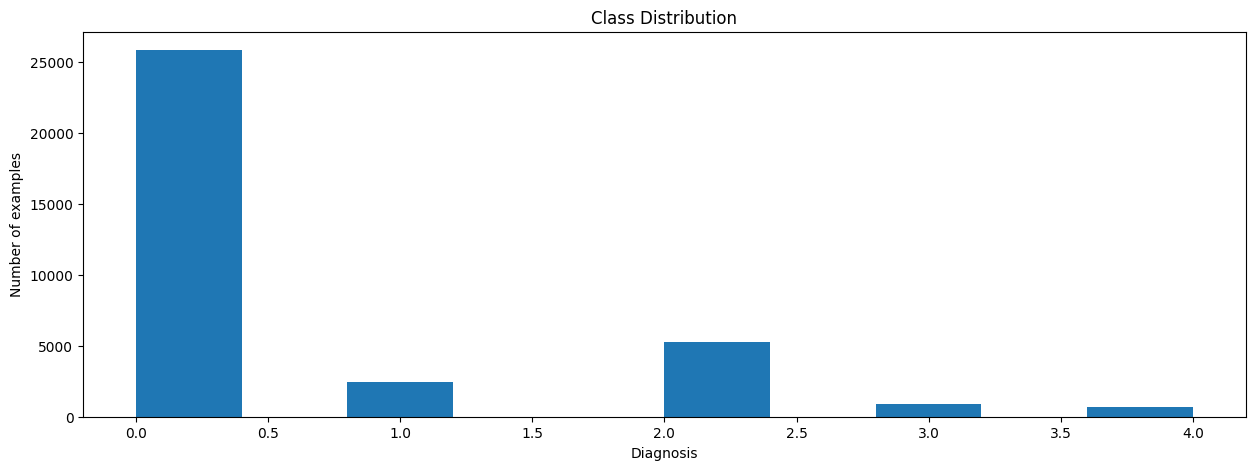

In [36]:
# CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

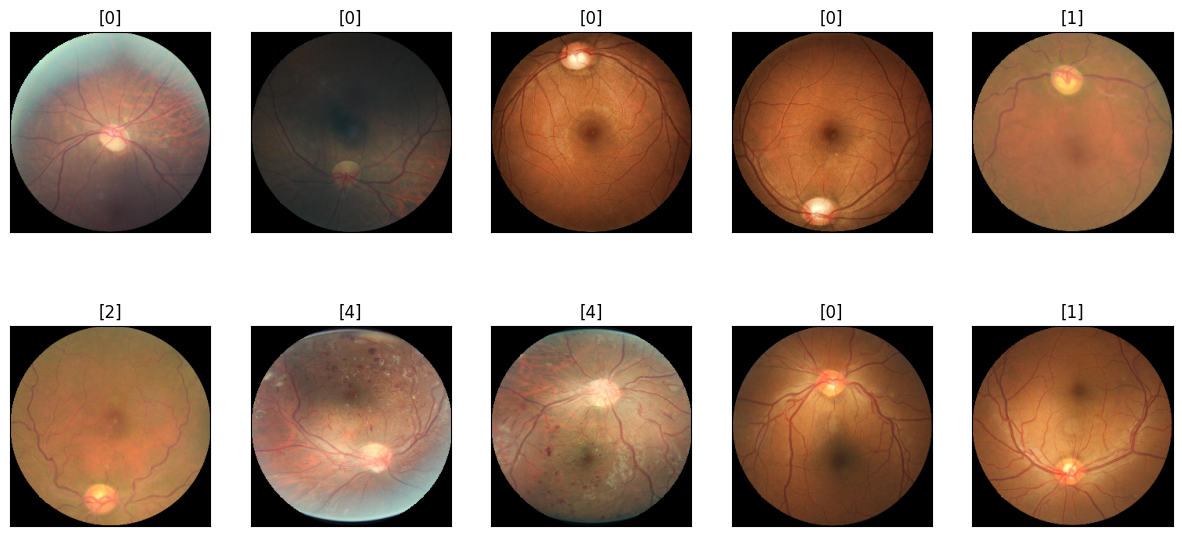

In [37]:
# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])
sample = Data(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = sample_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [38]:
# IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/diabetic-retinopathy-resized/resized_train/resized_train/{}.jpeg'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']

  0%|          | 0/35126 [00:00<?, ?it/s]

Text(0.5, 0, 'Ratio')

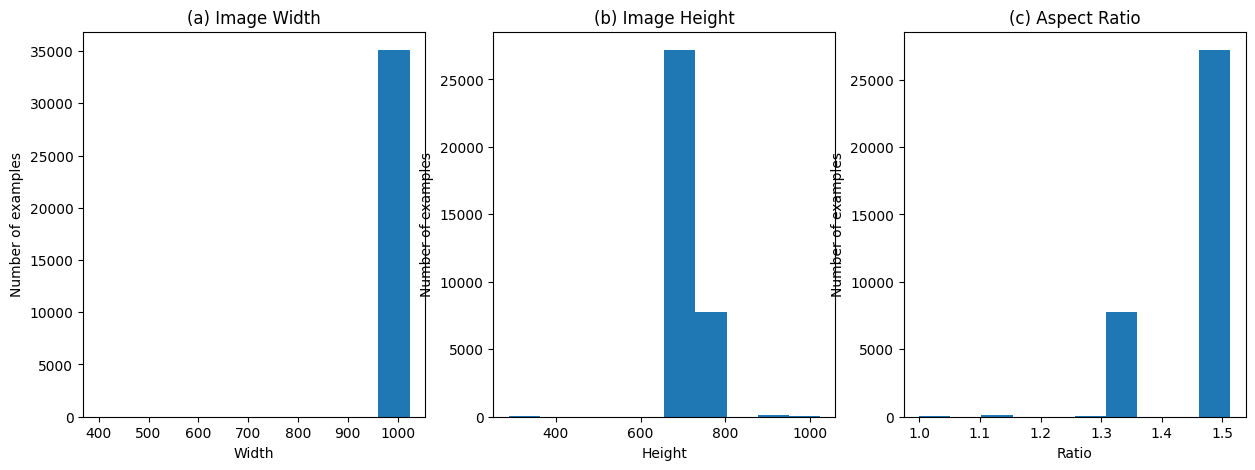

In [39]:
# IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

<a name='2-3'></a>
## 2.3  Preprocess and Augment Training Data

In [40]:
#TRANSFORMATIONS

# parameters
batch_size = 16
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

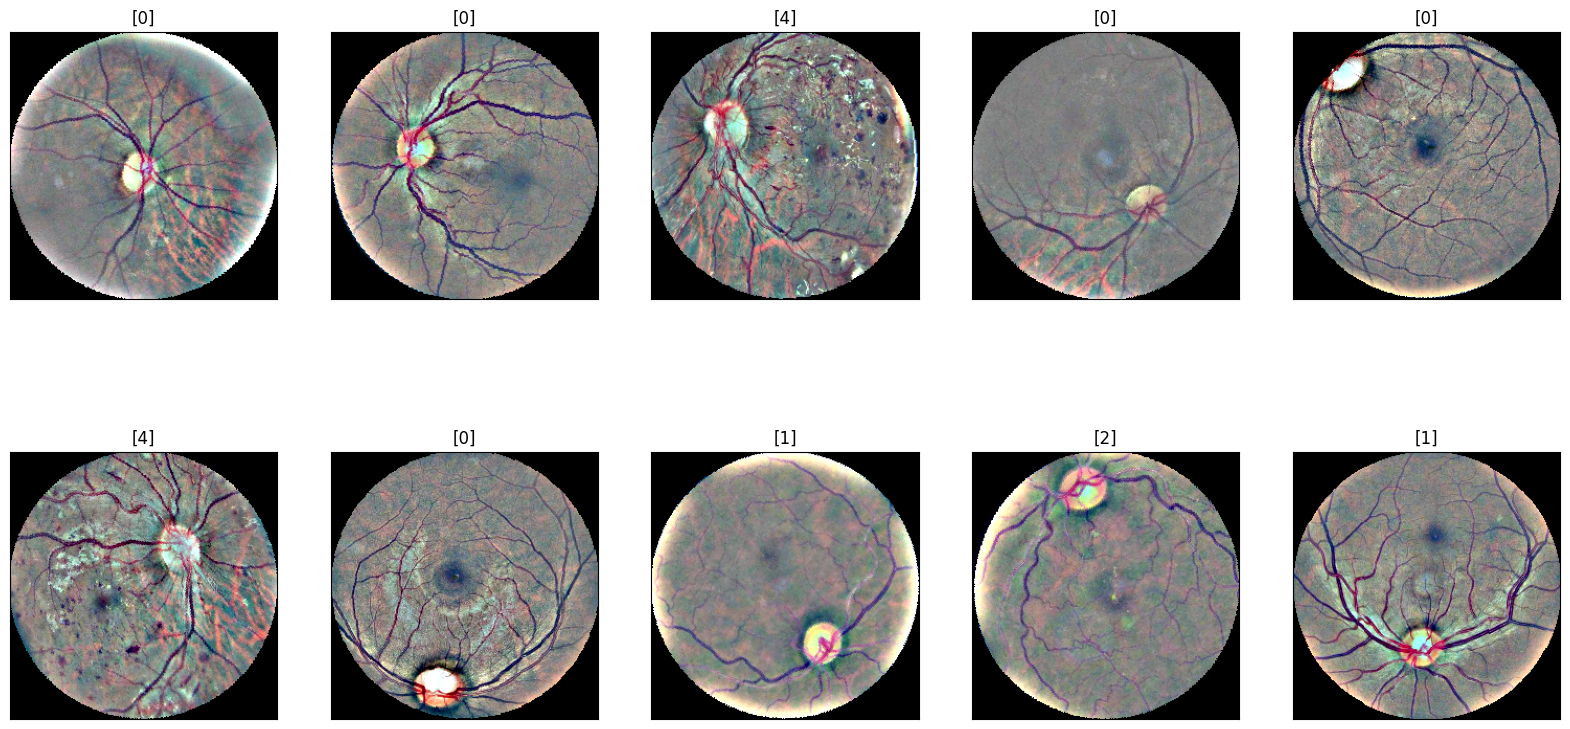

In [41]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = train_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

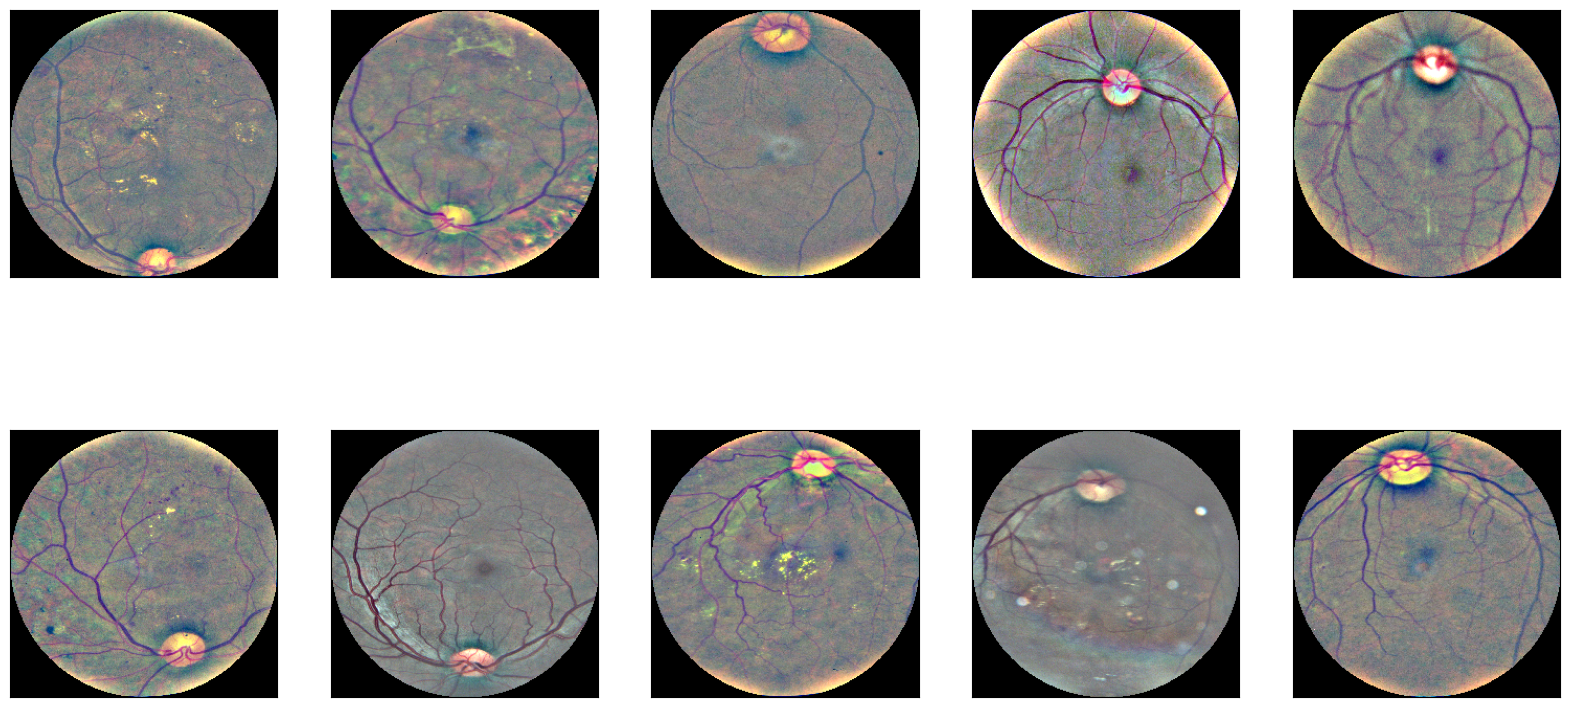

In [42]:
#EXAMINE FIRST BATCH (TEST)

# get dataset
sample = EyeData(data       = test.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/train_images',
                      transform  = test_trans,
                      itype ='.png',
                      do_random_crop = False)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break

<a name='2-4'></a>
## 2.4 - Using EFfienctNet for Transfer Learning
<center><img src="https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s1600/image2.png" width="1400" height="500x"></center>

<a name='2-4-1'></a>
### 2.4.1 - Setup Model and Choose Hyperparameters

In [43]:
#MODEL ARCHITECTURE

# model name
model_name = 'enet_b7'

# initialization function
def init_pre_model(train = True):
    
    '''
    Initialize the model
    '''
    
    ### training mode
    if train == True:
        
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b7', num_classes = 5)
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b7')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False
            
    ### return model
    return model


# check architecture
model = init_pre_model()
print(model)

Loaded pretrained weights for efficientnet-b7
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, ke

In [44]:
#VALIDATION SETTINGS

# placeholders
oof_preds = np.zeros((len(test), 5))

# timer
cv_start = time.time()

In [45]:
#PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 10 #15
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

<a name='2-4-2'></a>
## 2.4.2 - Train Model on Diabetic Retinopathy 2015 data

In [46]:
#DATA PREPARATION

# load splits
data_train = train
data_valid = test

# create datasets
train_dataset = EyeData(data      = data_train, 
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans,
                             itype ='.jpeg')
valid_dataset = EyeData(data       = data_valid, 
                            directory  = '../input/aptos2019-blindness-detection/train_images',
                            transform  = valid_trans,
                            itype ='.png')

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 4)

In [ ]:
#MODELING EPOCHS

# placeholders
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

# initialize and send to GPU
model = init_pre_model()
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# training and validation loop
for epoch in range(max_epochs):
    ### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    #TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    #INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(valid_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    #EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    #EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # # save model weights if improvement
    # if bad_epochs == 0:
    #     oof_preds_best = oof_preds.copy()
    #     torch.save(model.state_dict(), 'models/model_{}.bin'.format(model_name))
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
    
        import os
        os.makedirs('/kaggle/working/models', exist_ok=True)
        torch.save(model.state_dict(), '/kaggle/working/models/model_{}_full.bin'.format(model_name))
        print("✅ Saved full model to /kaggle/working/models/model_{}_full.bin".format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break


# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

Loaded pretrained weights for efficientnet-b7
- epoch 1/10 | lr = 0.001 | trn_loss = 0.7384 | val_loss = 0.9287 | val_kappa = 0.7859 | 26.51 min
✅ Saved full model to /kaggle/working/models/model_enet_b7_full.bin
- epoch 2/10 | lr = 0.001 | trn_loss = 0.6710 | val_loss = 0.9351 | val_kappa = 0.8095 | 26.25 min
✅ Saved full model to /kaggle/working/models/model_enet_b7_full.bin
- epoch 3/10 | lr = 0.001 | trn_loss = 0.6453 | val_loss = 0.8657 | val_kappa = 0.7456 | 26.28 min
- epoch 4/10 | lr = 0.001 | trn_loss = 0.6258 | val_loss = 0.8340 | val_kappa = 0.8438 | 26.26 min
✅ Saved full model to /kaggle/working/models/model_enet_b7_full.bin
- epoch 5/10 | lr = 0.00025 | trn_loss = 0.6078 | val_loss = 0.8856 | val_kappa = 0.8313 | 26.28 min
- epoch 6/10 | lr = 0.0005 | trn_loss = 0.5736 | val_loss = 1.1053 | val_kappa = 0.8376 | 26.40 min
- epoch 7/10 | lr = 0.0005 | trn_loss = 0.5584 | val_loss = 1.0003 | val_kappa = 0.8587 | 26.37 min


<a name='2-4-3'></a>

## 2.4.3 - Evaluation

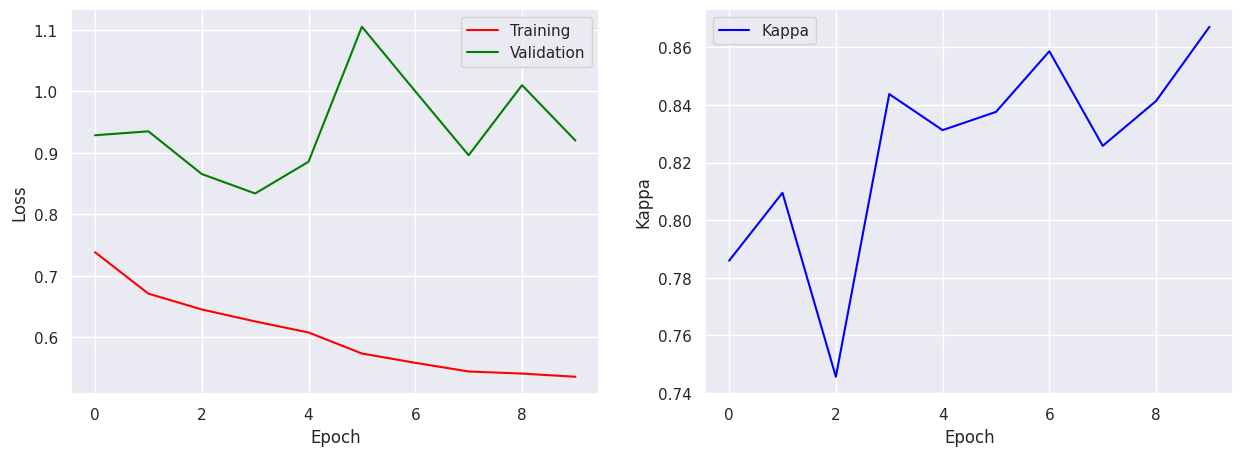

In [63]:
#PLOT LOSS AND KAPPA DYNAMICS
sns.set()
# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

In [91]:
#RECHECK PERFORMANCE

# rounding
oof_preds_round = oof_preds.argmax(axis = 1)
coef = [0.5, 1.5, 2.5, 3.5]
for i, pred in enumerate(oof_preds_round):
    if pred < coef[0]:
        oof_preds_round[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds_round[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds_round[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds_round[i] = 3
    else:
        oof_preds_round[i] = 4

# compute kappa
oof_loss  = criterion(torch.tensor(oof_preds), torch.tensor(test['diagnosis']).view(-1).type(torch.long))
oof_kappa = metrics.cohen_kappa_score(test['diagnosis'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF loss  = {:.4f}'.format(oof_loss))
print('OOF kappa = {:.4f}'.format(oof_kappa))

In [90]:
#CONFUSION MATRIX

# construct confusion matrix
cm = confusion_matrix(test['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

In [92]:
from sklearn.metrics import classification_report

#Classification Report Test
print('\n Classification Report in Test: \n',classification_report(test['diagnosis'], oof_preds_round))

<a name ="3"> </a>
# 3 - Training on Diabetic Retinopathy 2019 data
<center><img src = "https://i.imgur.com/pzwzeQj.png"/></center>

<a name ="3-1"> </a>
## 3.1 Import Data

In [72]:
# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))

(3662, 2) (1928, 2)
---------------
diagnosis
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: proportion, dtype: float64


<a name='3-2'></a>
## 3.2 Explore Data

Text(0.5, 0, 'Diagnosis')

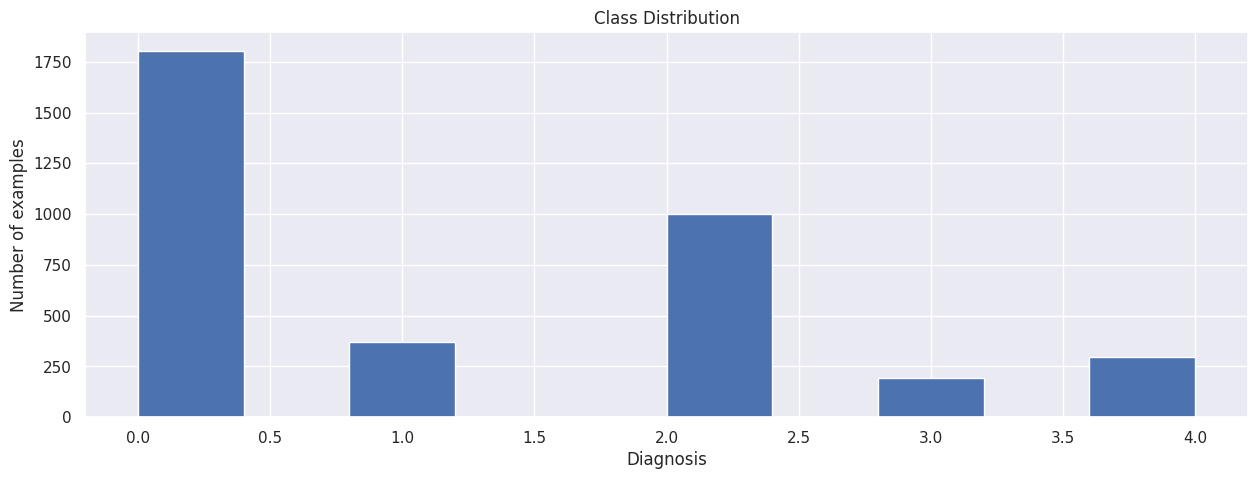

In [73]:
# CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

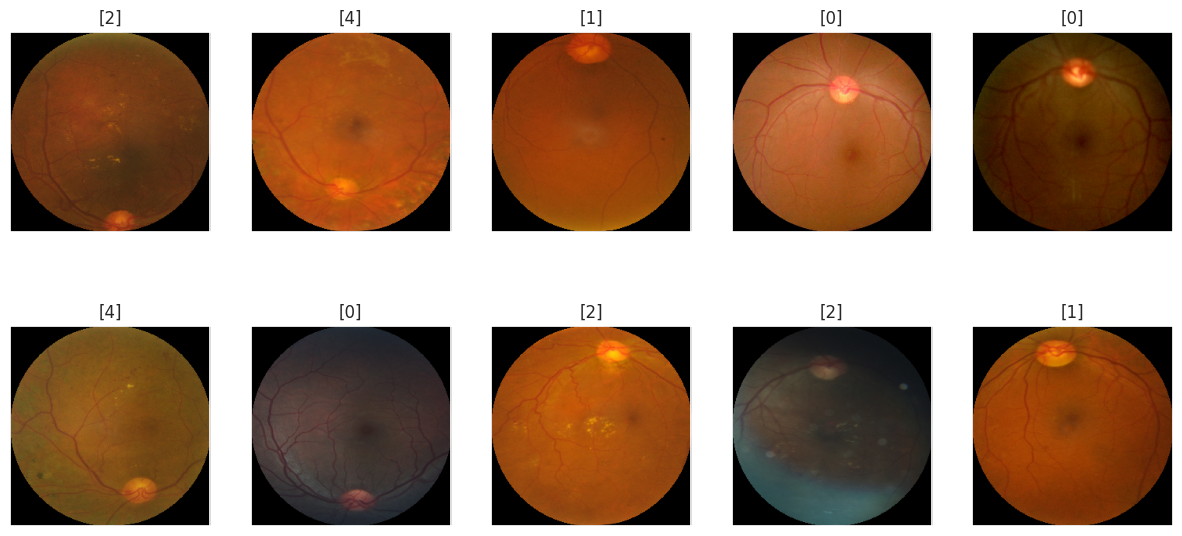

In [74]:
# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])
sample = Data(data       = train.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/train_images',
                      transform  = sample_trans,
                      itype ='.png')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [75]:
# IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']

  0%|          | 0/3662 [00:00<?, ?it/s]

Text(0.5, 0, 'Ratio')

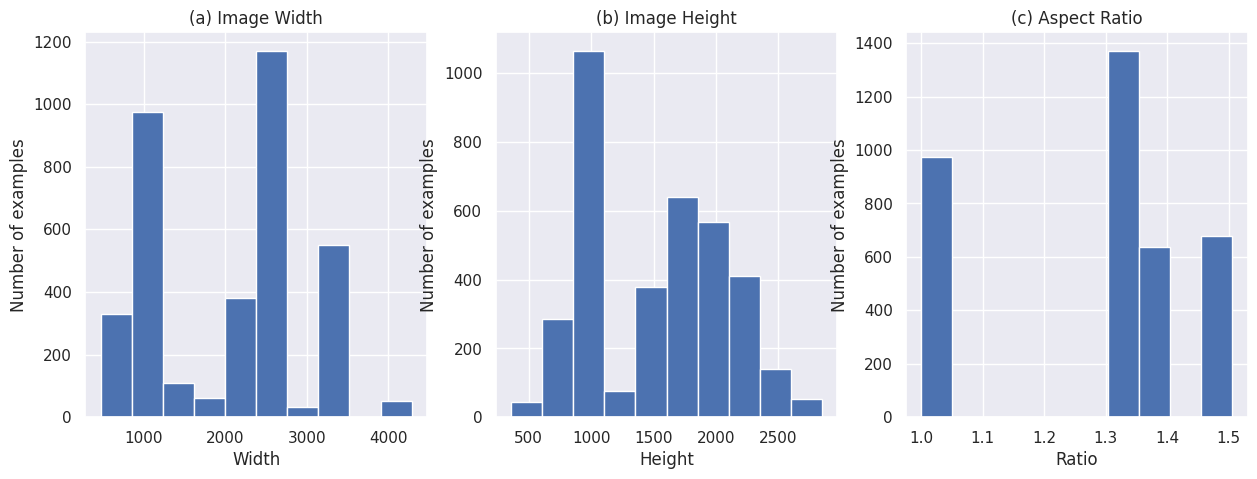

In [76]:
# IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

<a name ="3-3"> </a>
## 3.3 Preprocess and Augment Data

In [77]:
#TRANSFORMATIONS

# parameters
batch_size = 25
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor(),
                                 ])

# valid transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])
                                 
# test transformations
test_trans = valid_trans

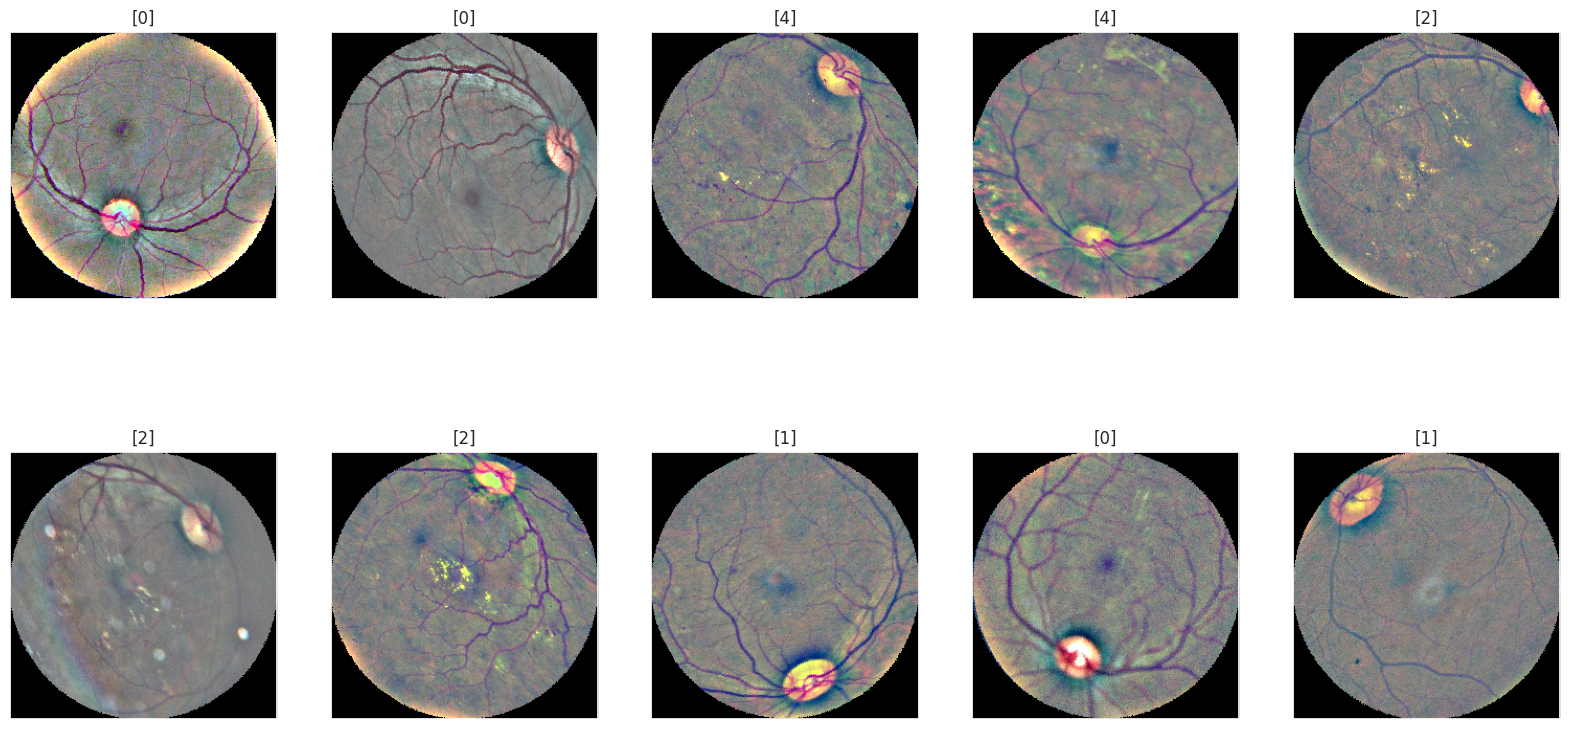

In [78]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data = train.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/train_images',
                      transform  = train_trans,
                      itype ='.png' )

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

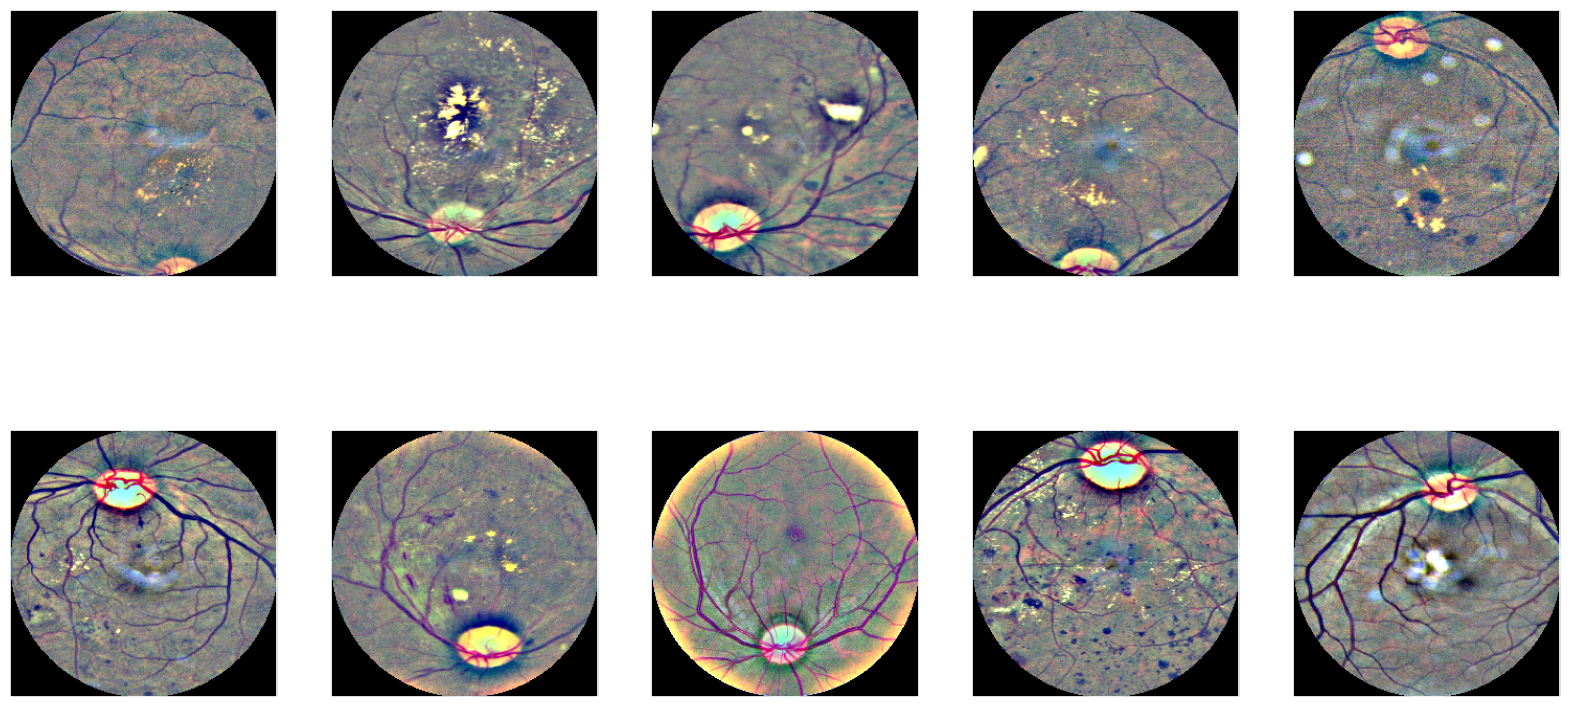

In [79]:
#EXAMINE FIRST BATCH (TEST)

# get dataset
sample = EyeData(data       = test.iloc[0:10], 
                      directory  = '../input/aptos2019-blindness-detection/test_images',
                      transform  = test_trans,
                      itype = '.png',
                      do_random_crop = False)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break

<a name="3-4"></a> 
## 3.4 - Load Pre-Trained EFfienctNetB7 trained on 2015 data
<center><img src = "https://miro.medium.com/max/1400/1*8oE4jOMfOXeEzgsHjSB5ww.png"/></center>

<a name ="3-4-1"></a>
### 3.4.1 Setup Model and Choose Hyperparameters

In [80]:
#MODEL ARCHITECTURE

# model name
model_name = 'enet_b7'

# check architecture
model = init_model(model_name = model_name)
print(model)

Loaded pretrained weights for efficientnet-b7
✅ Loaded pretrained weights from /kaggle/working/models/model_enet_b7_full.bin
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identi

In [81]:
#VALIDATION SETTINGS
from sklearn.model_selection import KFold, StratifiedKFold
# no. folds
num_folds = 4 #was 4 but didnt really had value so i made it 1

# creating splits
skf    = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = seed)
splits = list(skf.split(train['id_code'], train['diagnosis']))

# placeholders
oof_preds = np.zeros((len(train), 1))

# timer
cv_start = time.time()

In [82]:
#PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 10
early_stop = 5

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

<a name = "3-4-2"></a>
## 3.4.2 Train Model on Diabetic Retinopathy 2019 dat

In [83]:
#CROSS-VALIDATION LOOP
for fold in tqdm(range(num_folds)):
    
    
    #DATA PREPARATION

    # display information
    print('-' * 30)
    print('FOLD {}/{}'.format(fold + 1, num_folds))
    print('-' * 30)

    # load splits
    data_train = train.iloc[splits[fold][0]].reset_index(drop = True)
    data_valid = train.iloc[splits[fold][1]].reset_index(drop = True)

    # create datasets
    train_dataset = EyeData(data      = data_train, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = train_trans,
                                 itype = '.png')
    valid_dataset = EyeData(data      = data_valid, 
                                 directory = '../input/aptos2019-blindness-detection/train_images',
                                 transform = valid_trans,
                                 itype = '.png')

    # create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = True, 
                                               num_workers = 4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size  = batch_size, 
                                               shuffle     = False, 
                                               num_workers = 4)
    
    
    #MODEL PREPARATION
    
    # placeholders
    val_kappas = []
    val_losses = []
    trn_losses = []
    bad_epochs = 0
    
    # load best OOF predictions
    if fold > 0:
        oof_preds = oof_preds_best.copy()
    
    # initialize and send to GPU
    model = init_model(train = True)
    model = model.to(device)

    # optimizer
    optimizer = optim.Adam(model._fc.parameters(), lr = eta)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)
    
    
    #TRAINING AND VALIDATION LOOP
    for epoch in range(max_epochs):

        ## PREPARATION

        # timer
        epoch_start = time.time()

        # reset losses
        trn_loss = 0.0
        val_loss = 0.0

        # placeholders
        fold_preds = np.zeros((len(data_valid), 1))


        # TRAINING

        # switch regime
        model.train()
        
        # loop through batches
        for batch_i, data in enumerate(train_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)
            optimizer.zero_grad()

            # forward and backward pass
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss  = criterion(preds, labels)
                loss.backward()
                optimizer.step()

            # compute loss
            trn_loss += loss.item() * inputs.size(0)


        # INFERENCE
        
        # initialize
        model.eval()

        # loop through batches
        for batch_i, data in enumerate(valid_loader):

            # extract inputs and labels
            inputs = data['image']
            labels = data['label'].view(-1)
            inputs = inputs.to(device, dtype = torch.float)
            labels = labels.to(device, dtype = torch.long)

            # compute predictions
            with torch.set_grad_enabled(False):
                preds = model(inputs).detach()
                _, class_preds = preds.topk(1)
                fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = class_preds.cpu().numpy()

            # compute loss
            loss      = criterion(preds, labels)
            val_loss += loss.item() * inputs.size(0)

        # save predictions
        oof_preds[splits[fold][1]] = fold_preds
        
        # scheduler step
        scheduler.step()


        # EVALUATION

        # evaluate performance
        fold_preds_round = fold_preds
        val_kappa = metrics.cohen_kappa_score(data_valid['diagnosis'], fold_preds_round.astype('int'), weights = 'quadratic')
        
        # save perfoirmance values
        val_kappas.append(val_kappa)
        val_losses.append(val_loss / len(data_valid))
        trn_losses.append(trn_loss / len(data_train))

        
        # EARLY STOPPING
        
        # display info
        print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
            epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
            trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
            (time.time() - epoch_start) / 60))
        
        # check if there is any improvement
        if epoch > 0:       
            if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
                bad_epochs += 1
            else:
                bad_epochs = 0

        # # save model weights if improvement..
        if bad_epochs == 0:
            oof_preds_best = oof_preds.copy()
            # torch.save(model.state_dict(), 'models/model_{}_fold{}.bin'.format(model_name, fold + 1))
            import os
            os.makedirs('/kaggle/working/models', exist_ok=True)
            torch.save(model.state_dict(), '/kaggle/working/models/model_{}_fold{}.bin'.format(model_name, fold + 1))
            print(f"✅ Saved fold {fold + 1} model to /kaggle/working/models/model_{model_name}_fold{fold + 1}.bin")

        # break if early stop
        if bad_epochs == early_stop:
            print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break

        # break if max epochs
        if epoch == (max_epochs - 1):
            print('Did not meet early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
                np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
            print('')
            break
        

# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

  0%|          | 0/4 [00:00<?, ?it/s]

------------------------------
FOLD 1/4
------------------------------
Loaded pretrained weights for efficientnet-b7
✅ Loaded pretrained weights from /kaggle/working/models/model_enet_b7_full.bin
- epoch 1/10 | lr = 0.001 | trn_loss = 0.6436 | val_loss = 0.5389 | val_kappa = 0.8567 | 4.70 min
✅ Saved fold 1 model to /kaggle/working/models/model_enet_b7_fold1.bin
- epoch 2/10 | lr = 0.001 | trn_loss = 0.5742 | val_loss = 0.5281 | val_kappa = 0.8670 | 4.68 min
✅ Saved fold 1 model to /kaggle/working/models/model_enet_b7_fold1.bin
- epoch 3/10 | lr = 0.001 | trn_loss = 0.5699 | val_loss = 0.5160 | val_kappa = 0.8640 | 4.64 min
- epoch 4/10 | lr = 0.001 | trn_loss = 0.5454 | val_loss = 0.4993 | val_kappa = 0.8641 | 4.69 min
- epoch 5/10 | lr = 0.00025 | trn_loss = 0.5400 | val_loss = 0.5184 | val_kappa = 0.8537 | 4.72 min
- epoch 6/10 | lr = 0.0005 | trn_loss = 0.5283 | val_loss = 0.5154 | val_kappa = 0.8525 | 4.75 min
- epoch 7/10 | lr = 0.0005 | trn_loss = 0.5384 | val_loss = 0.5092 | va

<a name ="3-4-3"></a>
## 3.4.3 - Evaluation


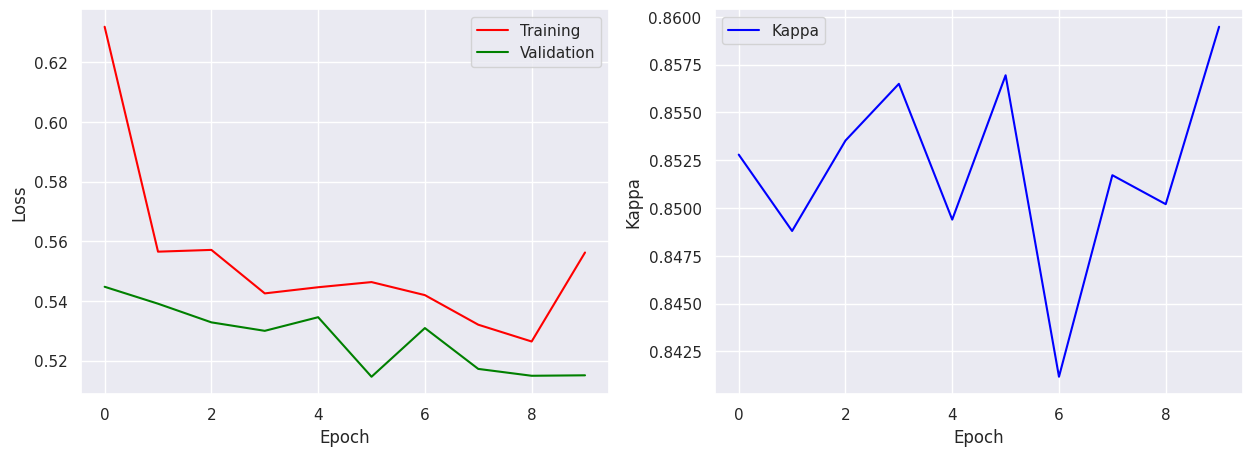

In [84]:
# PLOT LOSS AND KAPPA DYNAMICS
sns.set()
# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

In [85]:
#RECHECK PERFORMANCE

# evaluate performance
oof_preds_round = oof_preds.copy()
oof_kappa = metrics.cohen_kappa_score(train['diagnosis'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF kappa = {:.4f}'.format(oof_kappa))

OOF kappa = 0.8690


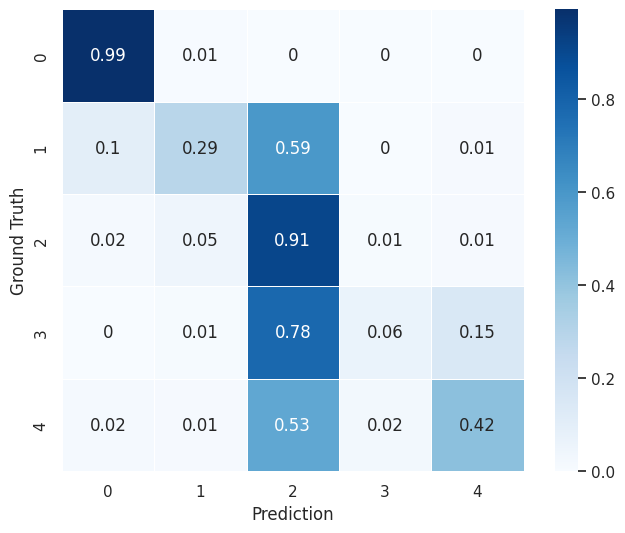

In [86]:
#CONFUSION MATRIX

# construct confusion matrx
cm = confusion_matrix(train['diagnosis'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

In [87]:
from sklearn.metrics import classification_report

#Classification Report Test
print('\n Classification Report in Test: \n',classification_report(train['diagnosis'], oof_preds_round))


 Classification Report in Test: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1805
           1       0.63      0.29      0.40       370
           2       0.63      0.91      0.75       999
           3       0.44      0.06      0.11       193
           4       0.72      0.42      0.53       295

    accuracy                           0.80      3662
   macro avg       0.68      0.53      0.55      3662
weighted avg       0.79      0.80      0.77      3662



In [88]:
print("done")

done
